In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
import nltk
from sklearn.model_selection import train_test_split

In [3]:
df= pd.read_csv("restaurant.csv")

In [4]:
df.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,2370338,_WTGv5XnA-qb_XD1D7Z0jg,6PgdGb3HrZdsfl2GiULo8w,RESDUcs7fIiihp38-d6_6g,5,0,1,0,After getting food poisoning at the Palms hote...,2012-12-04 03:10:18
1,2370357,JlNnsvMPLK_1-X2hwzK24w,IS9yw8P2uAPBX6FNLLX4KA,RESDUcs7fIiihp38-d6_6g,4,39,21,29,"""A feast worthy of Gods""\n\nBaccarnal Buffet i...",2014-01-17 00:50:50
2,2370373,hBkoWffORRb6aqKhC_Li2A,uZdFsE_aHbFBChgN6Xa8tw,RESDUcs7fIiihp38-d6_6g,4,1,1,1,The crab legs are better than the ones at Wick...,2015-06-08 18:03:09
3,2370411,rbkxvrgZg5kdCL2a66QYmA,8ZWJNAEWsymXDzKx3B0tTQ,RESDUcs7fIiihp38-d6_6g,1,0,0,0,Not worth it! Too salty food and expensive! Th...,2016-12-19 16:15:29
4,2370500,5tw_pedoHVi9bgeiBNsISg,E0sm4Ve7ifanFYeQMcV8Eg,RESDUcs7fIiihp38-d6_6g,5,0,0,0,I would give this infinite stars if I could. M...,2015-07-28 07:13:17


In [5]:
df["stars"].value_counts()

5    4247
4    2636
3    1561
1    1056
2     917
Name: stars, dtype: int64

In [6]:
df["year"]= pd.DatetimeIndex(df["date"]).year
df["month"]= pd.DatetimeIndex(df["date"]).year
df.drop(columns=["date"], inplace=True)

In [7]:
df.columns

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'year', 'month'],
      dtype='object')

In [8]:
df['sentiment'] = (
    np.select(condlist=[df['stars'] > 3, df['stars'] == 3, df['stars'] < 3], choicelist=["positive", "neutral", "negative"] ))
df= df[["stars", "sentiment", "text"]]
df.head()

,stars,sentiment,text
0,5,positive,After getting food poisoning at the Palms hote...
1,4,positive,"""A feast worthy of Gods""\n\nBaccarnal Buffet i..."
2,4,positive,The crab legs are better than the ones at Wick...
3,1,negative,Not worth it! Too salty food and expensive! Th...
4,5,positive,I would give this infinite stars if I could. M...


In [9]:
from textblob import TextBlob
import nltk
from nltk import word_tokenize
import string
import re
from textblob import Word
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect

In [10]:
def data_cleaning(df):
    stop_words= list(stopwords.words("english"))
    df["language"] = df["text"].apply(lambda x: detect(x))
    df = df[df["language"]=="en"] 
    
    df["improved_text"] = df["text"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    df["improved_text"] = df["improved_text"].apply(lambda x: word_tokenize(x.lower()))
    df["improved_text"]= df["improved_text"].apply(lambda x: [word for word in x if word not in stop_words])
    df["improved_text"]= df["improved_text"].apply(lambda x: " ".join(x))
    df["improved_text"]= df["improved_text"].apply(lambda x: WordNetLemmatizer().lemmatize(x))
    df["sentiment_polarity"]= df["improved_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
    df["sentiment_subjectivity"]= df["improved_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    return df
    

In [11]:
df = data_cleaning(df)

import re
import string


alphanumeric= lambda x: re.sub("\w*\d\w*", " ", x)
punc_lower= lambda x: re.sub("[%s]" % re.escape(string.punctuation), " ", x.lower())
new_line = lambda x: re.sub("\n", " ", x)

df["text"]= df.text.map(alphanumeric).map(punc_lower).map(new_line)
df.head()

from langdetect import detect

df["language"] = df["text"].apply(detect)

df = df[df["language"]=="en"]

In [12]:
df.drop(columns=["language", "text"], inplace=True)

In [13]:
df["sentiment"].value_counts()

positive    6853
negative    1964
neutral     1557
Name: sentiment, dtype: int64

In [14]:
df.head()

,stars,sentiment,improved_text,sentiment_polarity,sentiment_subjectivity
0,5,positive,getting food poisoning palms hotel scared eat ...,0.348197,0.611273
1,4,positive,feast worthy gods baccarnal buffet caesar pala...,0.222532,0.538945
2,4,positive,crab legs better ones wicked spoon huge prawns...,-0.134722,0.731944
3,1,negative,worth salty food expensive furst kast visit bu...,-0.100000,0.400000
4,5,positive,would give infinite stars could family diamond...,0.362500,0.725000


In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

X, y = df["improved_text"], df["sentiment"]
vect_CV= CountVectorizer()
vect_Tfid= TfidfVectorizer()
vect_CV_ngram= CountVectorizer(ngram_range=(2,3))
vect_Tfid_ngram= TfidfVectorizer(ngram_range=(2,3))
X_CV = vect_CV.fit_transform(X)
X_Tfid = vect_Tfid.fit_transform(X)
X_CV_ngram = vect_CV_ngram.fit_transform(X)
X_Tfid_ngram = vect_Tfid_ngram.fit_transform(X)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier ,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
log, knc, dtc, rfc = LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()
ada, gbc, mnb, bnb = AdaBoostClassifier(), GradientBoostingClassifier(), MultinomialNB(), BernoulliNB()

In [25]:
algorithms = [log, knc, dtc, rfc, ada, gbc, mnb, bnb]
names = ["LogisticRegression", "KNeighborsClassifier", "DecisionTreeClassifier", "RandomForestClassifier",
        "AdaBoostClassifier", "GradientBoostingClassifier", "MultinomialNB", "BernoulliNB"]
methods_data= [X_CV, X_Tfid, X_CV_ngram, X_Tfid_ngram]
method_names = ["CountVectorizer", "CountVectorizer, N-grams", "TF-IDF", "TF-IDF, N-grams"]

accuracy = []
precision = []
recall = []
f1 = []
methods = []
classifier = []
def classification():
    for j, method in enumerate(methods_data):
        name = method_names[j]
        X_var = method
        X_train, X_test, y_train, y_test = train_test_split(X_var, y, train_size=0.3, random_state=101)
        for i in range(len(algorithms)):
            algorithms[i].fit(X_train,y_train)
        for i in range(len(algorithms)):
            accuracy.append(accuracy_score(y_test,algorithms[i].predict(X_test)))
            precision.append(precision_score(y_test,algorithms[i].predict(X_test),average="macro"))
            recall.append(recall_score(y_test,algorithms[i].predict(X_test), average="macro"))
            f1.append(f1_score(y_test,algorithms[i].predict(X_test),average="macro"))
            methods.append(name)
            classifier.append(names[i])
            
            
    met= pd.DataFrame(columns= ["Classifier", "Methods", "Accuracy", "Precision", "Recall", "F1"])
    met["Classifier"] = classifier
    met["Methods"] = methods
    met["Accuracy"] = accuracy
    met["Precision"] = precision
    met["Recall"] = recall
    met["F1 score"] = f1
    return met

In [ ]:
algo_df = classification()

In [32]:
algo_df.sort_values(by="F1", ascending=False)

,Classifier,Methods,Accuracy,Precision,Recall,F1
0,LogisticRegression,CountVectorizer,0.775957,0.655375,0.631194,0.640170
8,LogisticRegression,"CountVectorizer, N-grams",0.776783,0.698810,0.564009,0.574494
22,MultinomialNB,TF-IDF,0.739190,0.606510,0.547905,0.563181
12,AdaBoostClassifier,"CountVectorizer, N-grams",0.733407,0.606577,0.545051,0.561942
4,AdaBoostClassifier,CountVectorizer,0.739603,0.606144,0.547732,0.560743
13,GradientBoostingClassifier,"CountVectorizer, N-grams",0.747039,0.664464,0.517508,0.539523
5,GradientBoostingClassifier,CountVectorizer,0.744148,0.651203,0.513357,0.533505
9,KNeighborsClassifier,"CountVectorizer, N-grams",0.710823,0.553104,0.514831,0.519279
2,DecisionTreeClassifier,CountVectorizer,0.656982,0.507487,0.498150,0.501669
25,KNeighborsClassifier,"TF-IDF, N-grams",0.705728,0.564133,0.476771,0.490236


In [45]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

SIA = SentimentIntensityAnalyzer()

df['scores'] = df['improved_text'].apply(lambda x: SIA.polarity_scores(x))
df["neg"] = df['scores'].apply(lambda x: x['neg'])
df["neu"] = df['scores'].apply(lambda x: x['neu'])
df["pos"] = df['scores'].apply(lambda x: x['pos'])
df["compound"] = df['scores'].apply(lambda x: x['compound'])
df.drop(columns="scores", inplace=True)



In [46]:
df.head()

,stars,sentiment,improved_text,sentiment_polarity,sentiment_subjectivity,neg,neu,pos,compound
0,5,positive,getting food poisoning palms hotel scared eat ...,0.348197,0.611273,0.127,0.539,0.334,0.9756
1,4,positive,feast worthy gods baccarnal buffet caesar pala...,0.222532,0.538945,0.074,0.680,0.246,0.9985
2,4,positive,crab legs better ones wicked spoon huge prawns...,-0.134722,0.731944,0.205,0.641,0.154,-0.6628
3,1,negative,worth salty food expensive furst kast visit bu...,-0.100000,0.400000,0.000,0.787,0.213,0.2263
4,5,positive,would give infinite stars could family diamond...,0.362500,0.725000,0.055,0.727,0.218,0.8017


In [47]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color= "white", mask= mask, max_words= 25000, stopwords=stopwords)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path= "wc.png"
    display(Image.open(path))

In [48]:
stars_1= df[df["stars"]==1]
stars_5= df[df["stars"]==5]
sentiment_positive = df[df["sentiment"]=="positive"]
sentiment_negative = df[df["sentiment"]=="negative"]

Word Cloud Saved Successfully


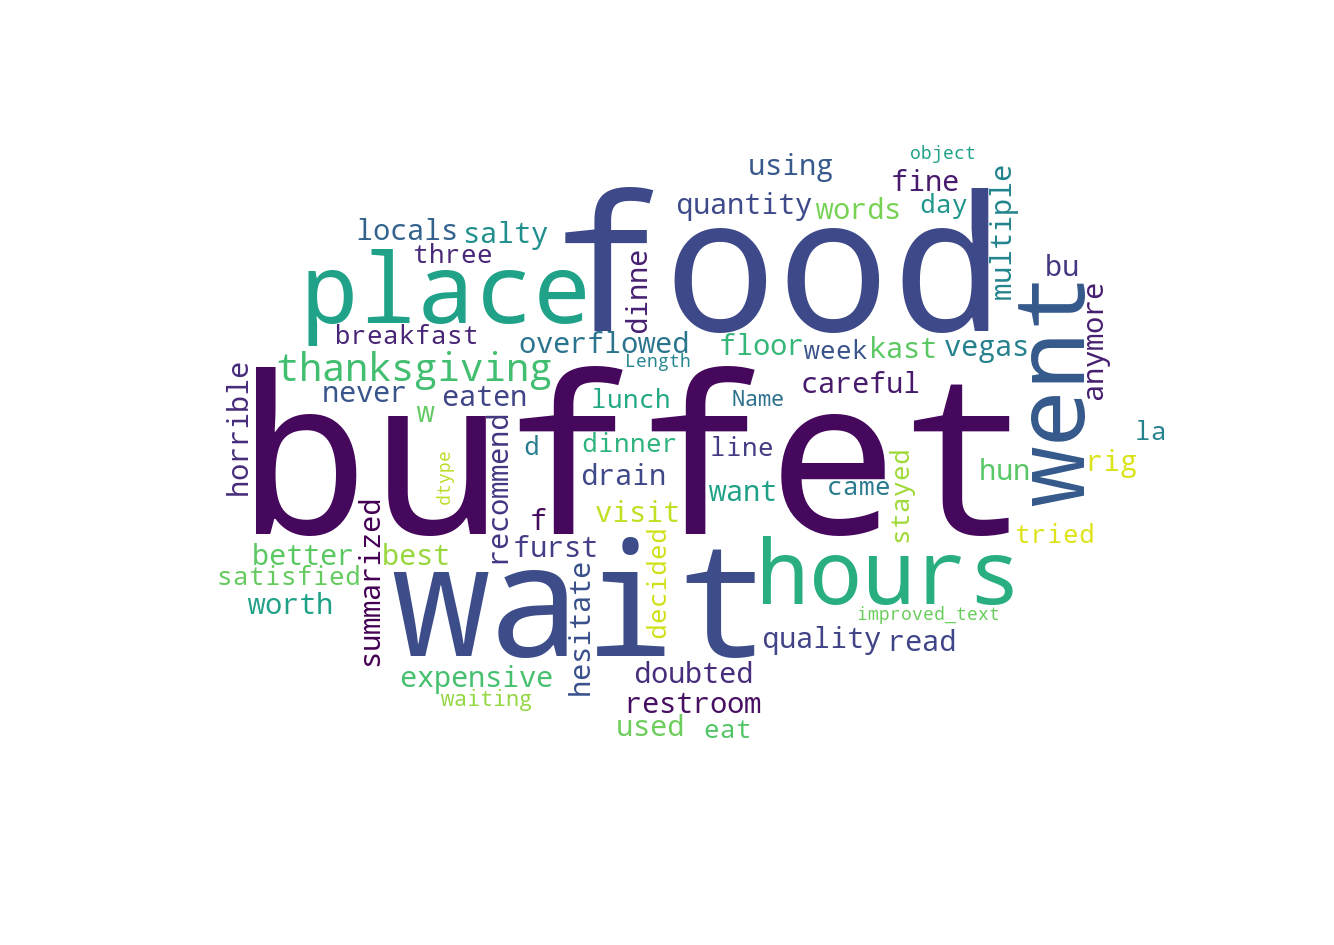

In [49]:
create_wordcloud(stars_1["improved_text"])

Word Cloud Saved Successfully


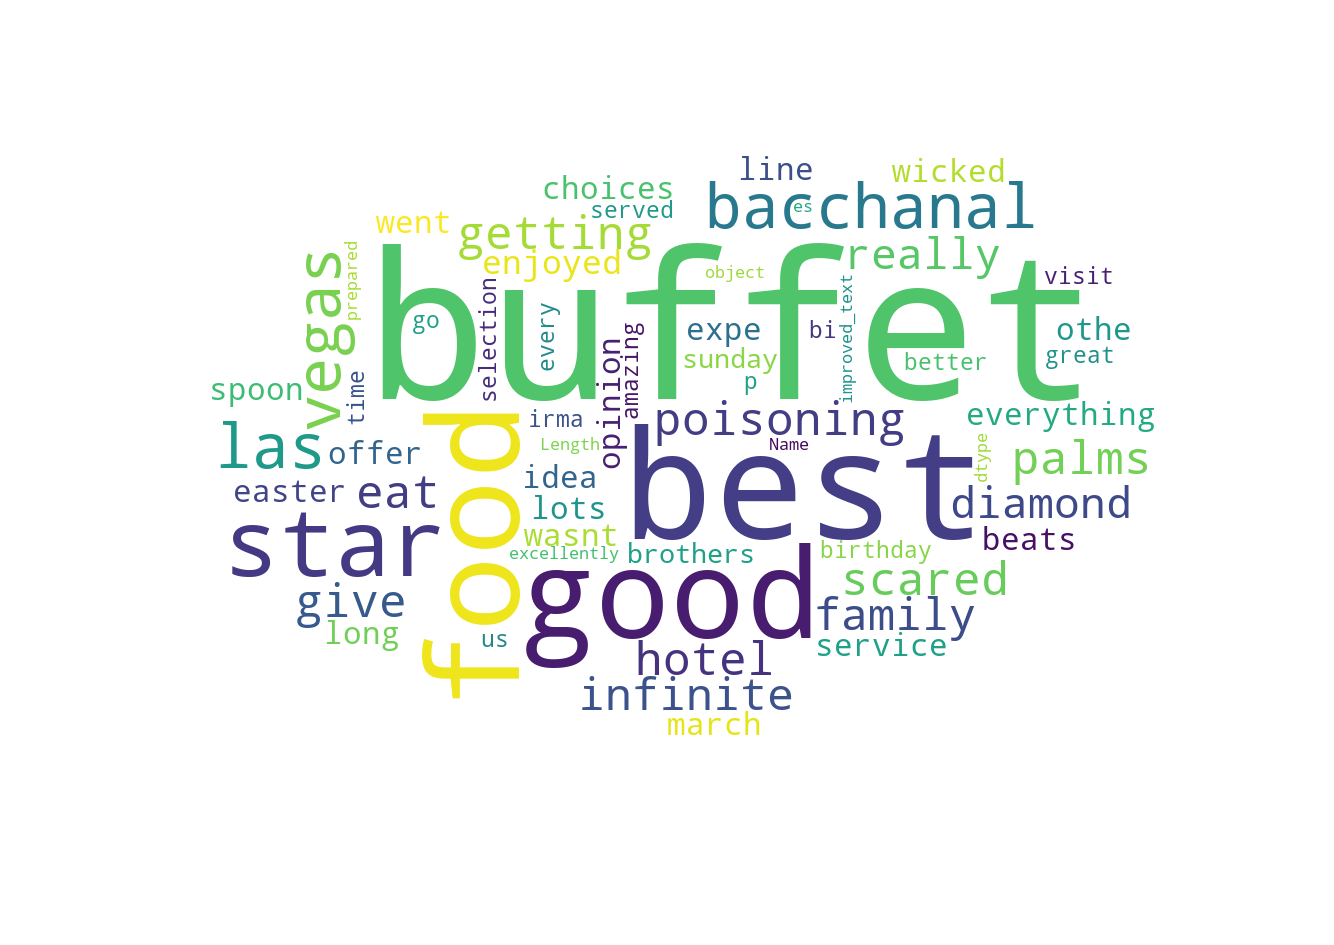

In [50]:
create_wordcloud(stars_5["improved_text"])

Word Cloud Saved Successfully


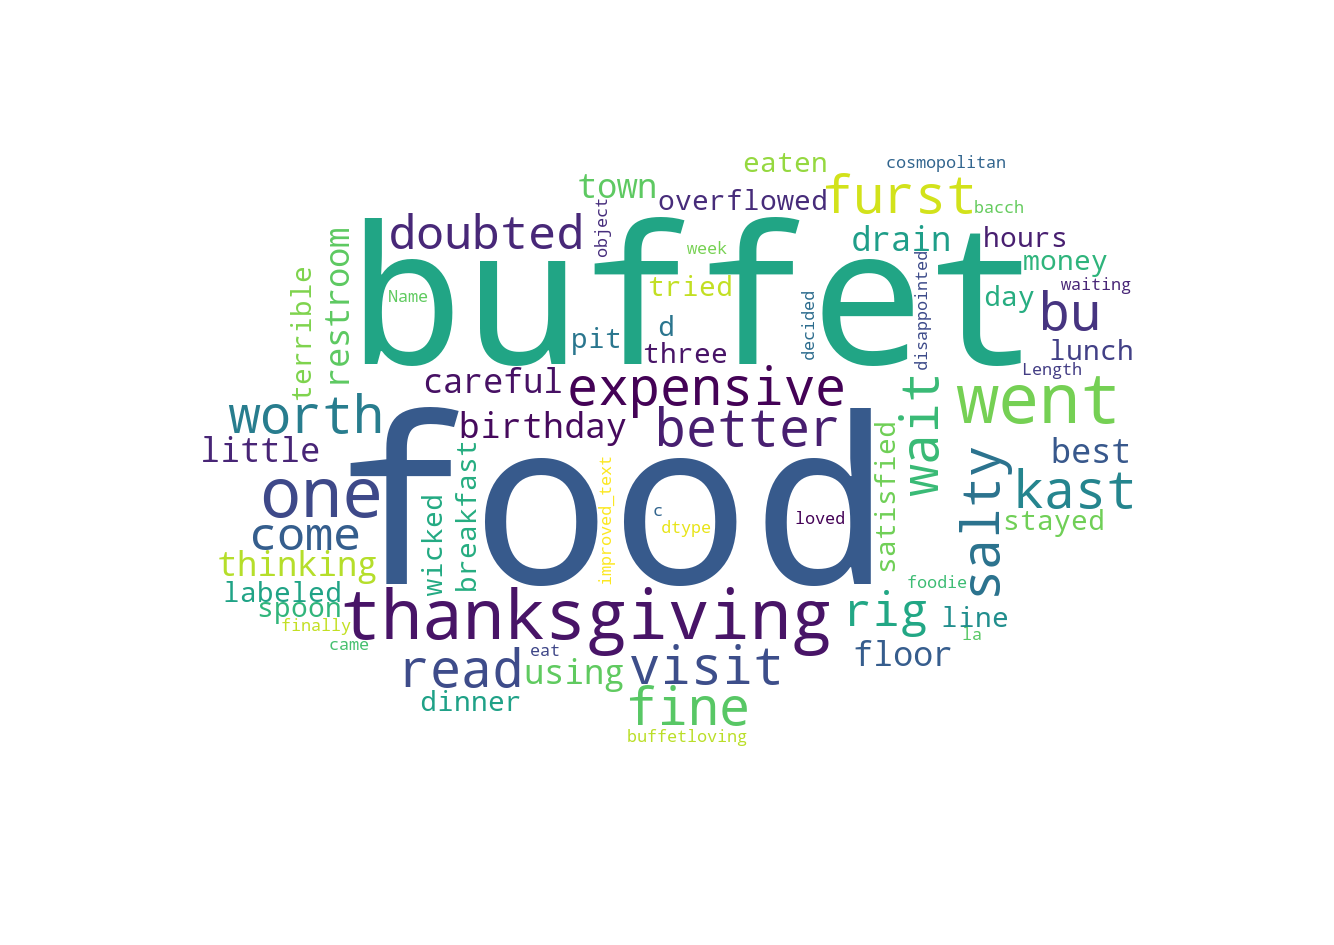

In [51]:
create_wordcloud(sentiment_negative["improved_text"])

Word Cloud Saved Successfully


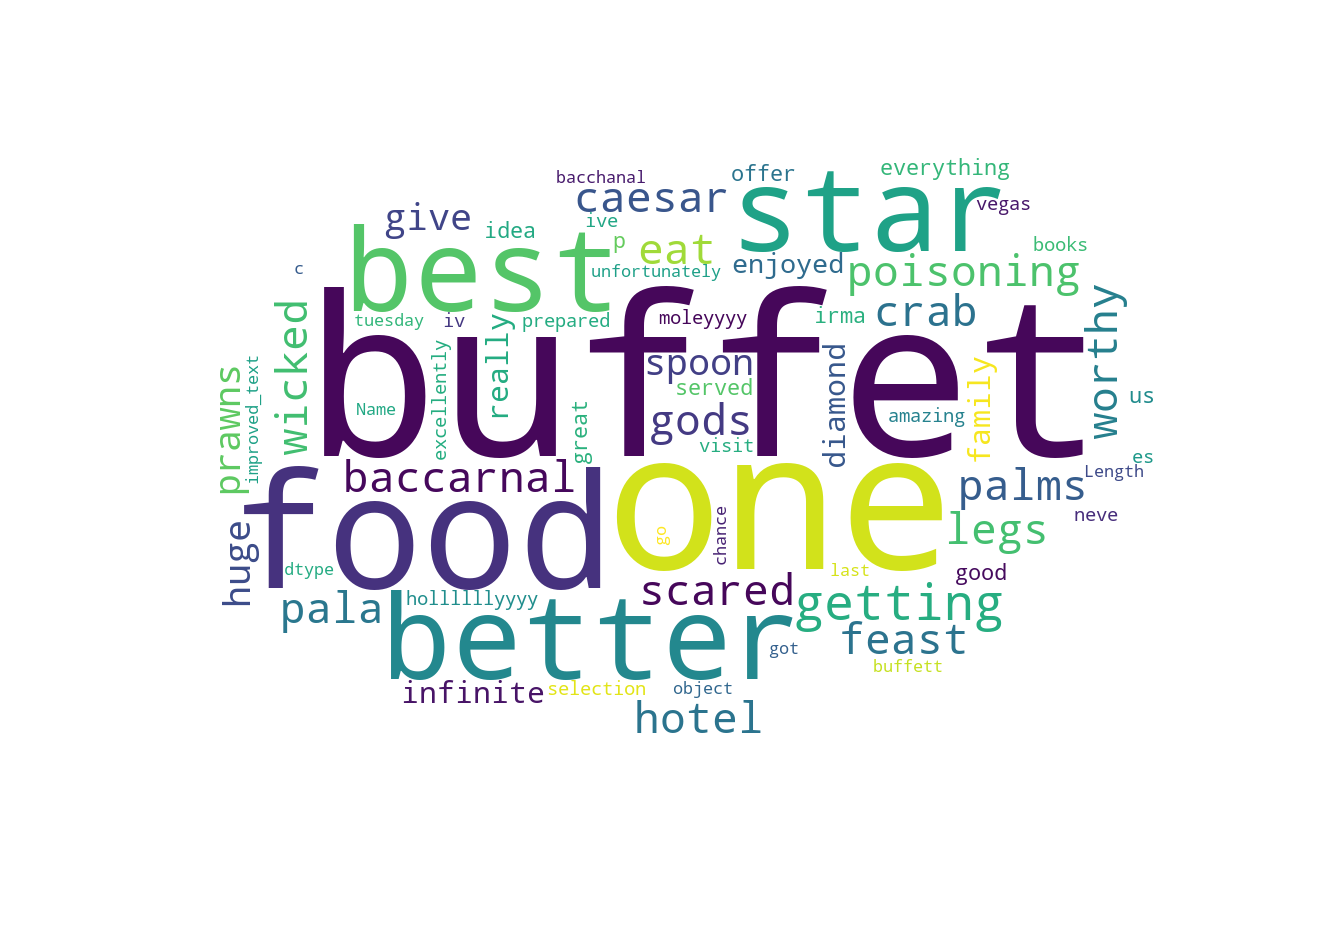

In [52]:
create_wordcloud(sentiment_positive["improved_text"])

In [70]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect_2_pos = CountVectorizer(ngram_range=(2,2))
vect_2_neg = CountVectorizer(ngram_range=(2,2))
vect_3_pos = CountVectorizer(ngram_range=(3,3))
vect_3_neg = CountVectorizer(ngram_range=(3,3))

df_2_pos = df[df["sentiment"]=="positive"]["improved_text"]
df_2_neg = df[df["sentiment"]=="negative"]["improved_text"]
df_3_pos = df[df["sentiment"]=="positive"]["improved_text"]
df_3_neg = df[df["sentiment"]=="negative"]["improved_text"]


X_count_2_pos = vect_2_pos.fit_transform(df_2_pos)
X_count_2_neg = vect_2_neg.fit_transform(df_2_neg)
X_count_3_pos = vect_3_pos.fit_transform(df_3_pos)
X_count_3_neg = vect_3_neg.fit_transform(df_3_neg)

X_count_2_pos= X_count_2_pos.astype(dtype="uint8")
X_count_2_neg= X_count_2_neg.astype(dtype="uint8")
X_count_3_pos= X_count_3_pos.astype(dtype="uint8")
X_count_3_neg= X_count_3_neg.astype(dtype="uint8")


shape_X_2_pos= X_count_2_pos.shape
shape_X_2_neg= X_count_2_neg.shape
shape_X_3_pos= X_count_3_pos.shape
shape_X_3_neg= X_count_3_neg.shape

X_a_2_pos = X_count_2_pos.toarray()
X_a_2_neg = X_count_2_neg.toarray()
X_a_3_pos = X_count_3_pos.toarray()
X_a_3_neg = X_count_3_neg.toarray()


X_a_2_pos = np.reshape(X_a_2_pos, shape_X_2_pos)
X_a_2_neg = np.reshape(X_a_2_neg, shape_X_2_neg)
X_a_3_pos = np.reshape(X_a_3_pos, shape_X_3_pos)
X_a_3_neg = np.reshape(X_a_3_neg, shape_X_3_neg)

In [71]:
columns_2_pos = vect_2_pos.get_feature_names()
columns_2_neg = vect_2_neg.get_feature_names()
columns_3_pos = vect_3_pos.get_feature_names()
columns_3_neg = vect_3_neg.get_feature_names()


df_2_pos = pd.DataFrame(X_a_2_pos, columns = columns_2_pos)
df_2_neg = pd.DataFrame(X_a_2_neg, columns = columns_2_neg)
df_3_pos = pd.DataFrame(X_a_3_pos, columns = columns_3_pos)
df_3_neg = pd.DataFrame(X_a_3_neg, columns = columns_3_neg)


In [72]:
first_10_2_words_pos= df_2_pos.sum().sort_values(ascending=False)[0:10]
first_10_2_words_pos

crab legs           2417
best buffet         1386
prime rib           1099
buffet vegas         809
las vegas            687
dim sum              595
bacchanal buffet     588
come back            560
wicked spoon         542
ice cream            502
dtype: int64

In [73]:
first_10_2_words_neg= df_2_neg.sum().sort_values(ascending=False)[0:10]
first_10_2_words_neg

crab legs           534
prime rib           256
per person          231
come back           206
king crab           204
wicked spoon        168
las vegas           146
bacchanal buffet    143
quality food        122
best buffet         122
dtype: int64

In [76]:
first_10_3_words_pos= df_3_pos.sum().sort_values(ascending=False)[0:10]
first_10_3_words_pos

best buffet vegas    441
king crab legs       310
buffet las vegas     226
best buffet ive      203
one best buffets     166
best buffet ever     156
buffet ive ever      156
snow crab legs       154
best buffet las      141
worth every penny    136
dtype: int64

In [77]:
first_10_3_words_neg= df_3_neg.sum().sort_values(ascending=False)[0:10]
first_10_3_words_neg

king crab legs       84
best buffet vegas    52
snow crab legs       44
60 per person        34
buffet las vegas     29
go wicked spoon      26
never go back        24
go somewhere else    23
dont waste money     21
save money go        21
dtype: int64